In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

%matplotlib inline

matplotlib.rcParams["font.family"] = "Helvetica Neue"
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams.update({"axes.grid" : True, "grid.color": "grey", "grid.alpha": .2, 'xtick.direction':'in','ytick.direction':'in'})
%config InlineBackend.figure_format = 'retina'

e_col = '#e42536'
h_col = '#570efc'
c_col = '#f89c20'

w_mf2 = np.loadtxt('sim/MF_2.txt')
w_mf1 = np.loadtxt('sim/MF_1.txt')

In [4]:
def beam_mapper1(freq, anglee, date, c):

    #helper function to generate the plotted data
    def beam_plot(freq,anglee,date,c):
        csv='sim/v11_3_cross.csv'                                   #filename for simulated data from csv
        data2 = genfromtxt(csv, delimiter=',', skip_header=1)       #read file into memory
        theta=data2[:,0]
        theta_r=theta[::-1]*-1.
        theta_full=np.concatenate([theta_r,theta])
                                                                    #whether or not the data2 includes Ccut of phi
        if c==1:
            name=['Ecut','Hcut','Ccut']
        else:
            name=['Ecut','Hcut']
                                                                    #
        E_ind=(freq-70)*3+1     #X phi=0
        H_ind=(freq-70)*3+3     #X phi=90
        C_ind=(freq-70)*3+320   #Y phi=45
        shift=np.zeros(2)
        top=np.zeros(2)        

        def running_mean(x, N):                                             #we use a running mean to increase SNR
                return np.convolve(x, np.ones((N,))/N)[(N-1):]

        for jj in range(len(name)):     #loop for each cut in the csv

            data=np.loadtxt('data/'+str(freq)+'GHz_'+str(anglee)+'deg_'+str(name[jj])+'_'+date+'.txt')
            ang=(len(data)-1) /2
            ang=np.linspace(-ang,ang,len(data))
            L_MEAN = 1
            N_INDIV = 5
            L=len(data[0,:])

            line_size = np.size(data[0])
            nsamp =  np.size(data,0)    #number of rows in data
            arr_f = np.zeros(nsamp)
            arr_x = np.zeros(nsamp)
            arr_y = np.zeros(nsamp)
            arr_phi = np.zeros(nsamp)
            amp_cross=np.zeros(nsamp)
            amp_phase=np.zeros(nsamp)
            amp_var=np.zeros(nsamp)
            phase=np.zeros(nsamp)
            z=[]

            i_AA_begin = int(N_INDIV + (1-1)*(line_size-N_INDIV)/4)
            i_AA_end= int(N_INDIV + (2-1)*(line_size-N_INDIV)/4) -1
            i_BB_begin = int(N_INDIV + (2-1)*(line_size-N_INDIV)/4)
            i_BB_end= int(N_INDIV + (3-1)*(line_size-N_INDIV)/4) -1
            i_AB_begin = int(N_INDIV + (3-1)*(line_size-N_INDIV)/4)
            i_AB_end= int(N_INDIV + (4-1)*(line_size-N_INDIV)/4) -1
            i_phase_begin = int(N_INDIV + (4-1)*(line_size-N_INDIV)/4)
            i_phase_end= int(N_INDIV + (5-1)*(line_size-N_INDIV)/4) -1


            for kk in range(nsamp):
                #take in raw DATA
                arr_f[kk] = data[kk][0]
                arr_x[kk] = data[kk][1]
                arr_y[kk] = data[kk][2]
                arr_phi[kk] = data[kk][3]
                index_signal = data[kk][4]
                arr_AA = np.array(running_mean(data[kk][i_AA_begin : i_AA_end],L_MEAN))
                arr_BB = np.array(running_mean(data[kk][i_BB_begin : i_BB_end],L_MEAN))
                arr_AB = np.array(running_mean(data[kk][i_AB_begin : i_AB_end],L_MEAN))
                arr_phase = np.array( data[kk][i_phase_begin : i_phase_end] )
                n_channels = np.size(arr_AB)

                #make amplitude arrays, in case they need to be plotted.
                amp_cross[kk] = arr_AB[int(n_channels/2)]
                amp_var[kk] = np.power( np.divide(arr_AB[int(n_channels/2)],arr_AA[int(n_channels/2)]) , 2)
                amp_phase[kk] = np.remainder(arr_phase[int(n_channels/2)],360.)

            power=amp_cross

            #Convert angle to angle of setup
            def func(x,a, b, c):  #fits a parabola to center of the data (recenters data to align with simulation)
                return a*(x-b)**2+c
            pguess=[-1.e3, 0.,1.e8]

            if jj==0:
                angle=ang
                popt,pcov=curve_fit(func,angle[(angle<10) & (angle>-10)],power[(angle<10) & (angle>-10)], p0=pguess)
                beam_center_a=popt[1]
                norm=popt[2]
                shift[0]=popt[1]
                top[0]=popt[2]
                norm_a=np.max(power)
                final_angle_a=angle-beam_center_a
                final_power_a=10*np.log10(power**2/norm**2)

            if jj==1:
                angle=ang
                popt,pcov=curve_fit(func,angle[(angle<20) & (angle>-20)],power[(angle<20) & (angle>-20)], p0=pguess)
                beam_center=popt[1]
                norm=popt[2]
                shift[1]=popt[1]
                top[1]=popt[2]
                norm_b=np.max(power)
                final_angle_b=angle-beam_center
                final_power_b=10*np.log10(power**2/norm**2)  

            if c==1:
                if jj==2:
                    angle_c=np.sqrt(2)*ang
                    beam_center_c=beam_center_a
                    norm_c=norm_a
                    final_angle_c=angle_c-beam_center_a
                    final_power_c=10*np.log10(power**2/norm**2)

        E=data2[:,E_ind]
        H=data2[:,H_ind]
        N=np.max(E)
        N_H=np.max(H)
        E_norm=E-N
        H_norm=H-N_H
        E_ind+=3*5
        H_ind+=3*5
        E_r=E_norm[::-1]
        H_r=H_norm[::-1]
        E_full=np.concatenate([E_r,E_norm])
        H_full=np.concatenate([H_r,H_norm])

        if c==1:
            C=data2[:,C_ind]
            C_norm=C-N
            C_ind+=3*5
            C_r=C_norm[::-1]
            C_full=np.concatenate([C_r,C_norm])
            
        if c==0:
            return theta_full,E_full,H_full,final_angle_a,final_power_a,final_angle_b,final_power_b
        else:
            return theta_full,E_full,H_full,C_full,final_angle_a,final_power_a,final_angle_b,final_power_b,final_angle_c,final_power_c

    thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = 0,0,0,0,0,0,0,0,0,0
    #thet_sim, e_sim1,h_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A = beam_plot(freq,anglee, date, c)

    if c==0:
        thet_sim,e_sim1,h_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A = beam_plot(freq,anglee, date, c)
    else:
        thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = beam_plot(freq,anglee, date, c)


    #make plots
    fig, ax = plt.subplots(1, 1,figsize = (12,8),sharey=True)
    e_col = '#e42536'
    h_col = '#570efc'
    c_col = '#f89c20'
    ax.plot(thet_c1_A,c1_A,'.-',color = c_col,label = 'C')
    ax.plot(thet_e1_A,e1_A,'.-',color = e_col,label = 'E')
    ax.plot(thet_h1_A,h1_A,'.-',color = h_col,label = 'H')
    ax.plot(thet_h1_A,c1_A,'.-',color = c_col)
    ax.plot(thet_e1_A,e1_A,'.-',color = e_col)
    ax.plot(thet_h1_A,h1_A,'.-',color = h_col)
    ax.plot(thet_sim,c_sim1,color = c_col,label = 'C sim')
    ax.plot(thet_sim,e_sim1,color = e_col,label = 'E sim')
    ax.plot(thet_sim,h_sim1,color = h_col,label = 'H sim')

    ax.set_title("%d$\,$GHz" %freq)
    ax.set_xlabel(r"$\theta\,$[deg.]")
    ax.set_ylabel("Power$\,$[dB]")
    ax.set_xlim(-60,65)
    ax.set_ylim(-55,0)

    lab_size = 20
    ax.legend(ncol=2,fontsize = lab_size, bbox_to_anchor = (0.7,1),shadow=True, facecolor="whitesmoke")

    ax.vlines(x=18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
    ax.vlines(x=-18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')

    ax.vlines(x=13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
    ax.vlines(x=-13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
    plt.tight_layout(w_pad=0.7)
    plt.show()
    return

findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


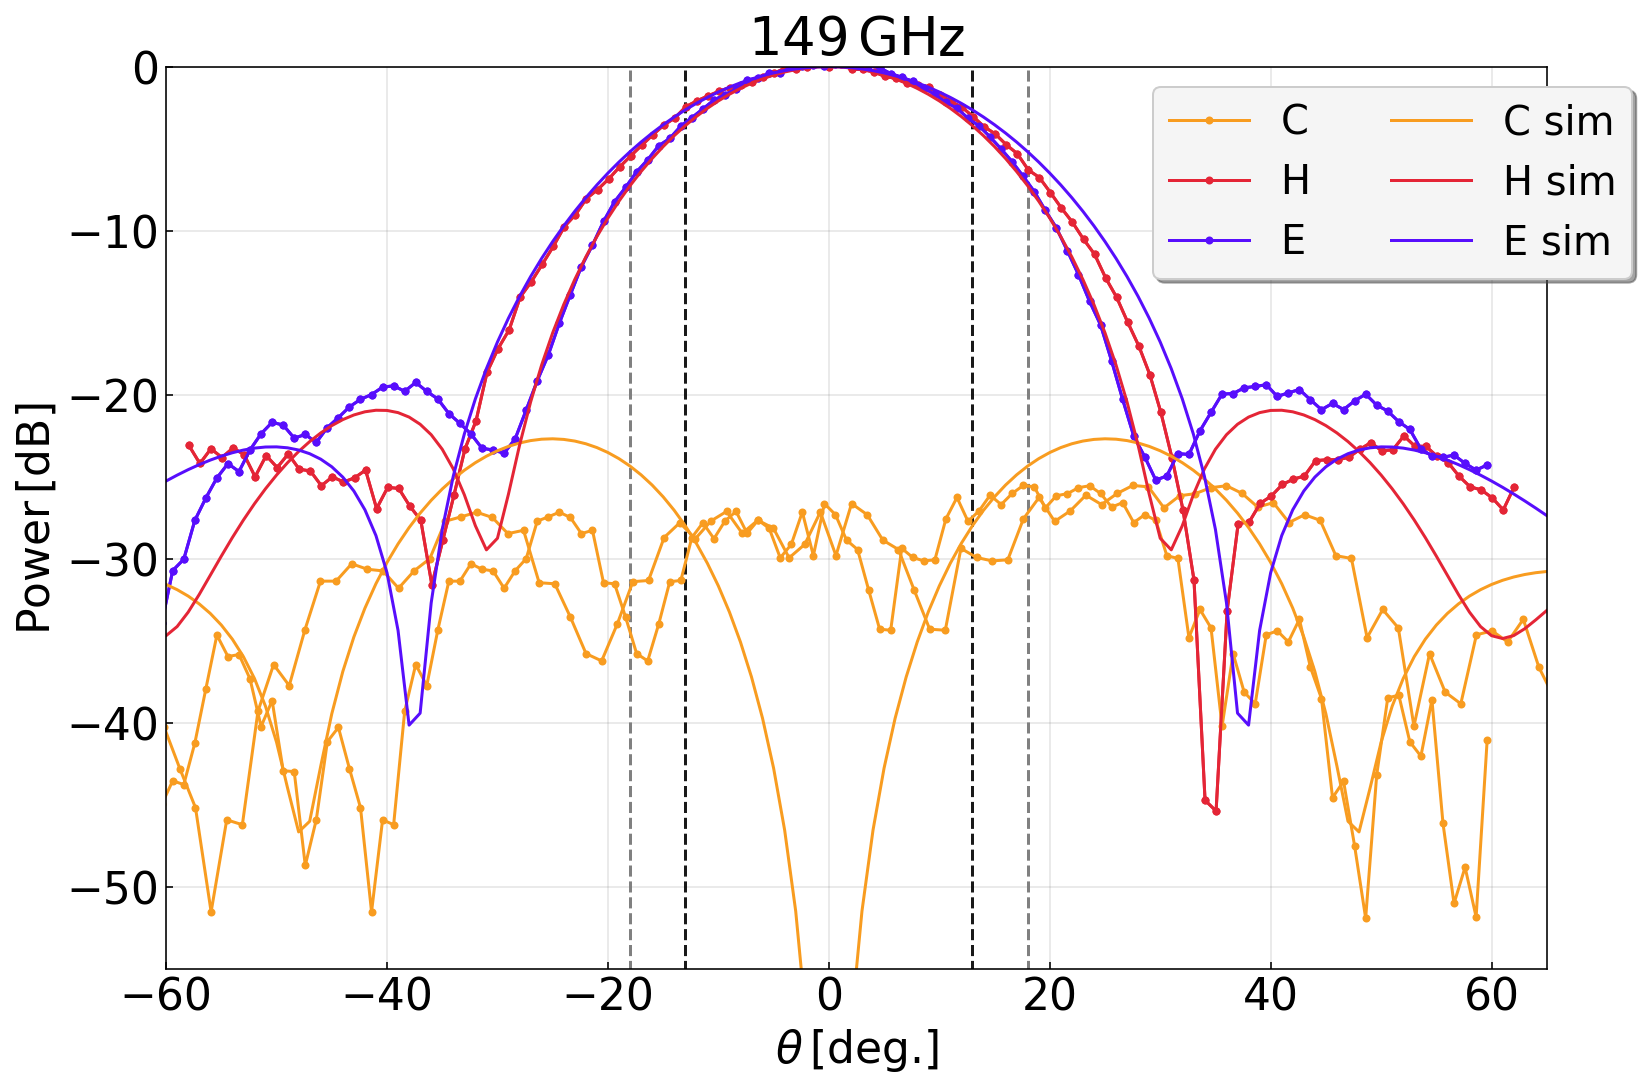

In [5]:
beam_mapper1(149,60, '21-1-2021',1)

In [11]:
#same function as above but with stopping angles
def beam_mapper2(freq, anglee, date, c,stop_angle):

    #helper function to generate the plotted data
    def beam_plot(freq,anglee,date,c):
        csv='sim/v11_3_cross.csv'                                   #filename for simulated data from csv
        data2 = genfromtxt(csv, delimiter=',', skip_header=1)       #read file into memory
        theta=data2[:,0]
        theta_r=theta[::-1]*-1.
        theta_full=np.concatenate([theta_r,theta])
                                                                    #whether or not the data2 includes Ccut of phi
        if c==1:
            name=['Ecut','Hcut','Ccut']
        else:
            name=['Ecut','Hcut']
                                                                    #
        E_ind=(freq-70)*3+1     #X phi=0
        H_ind=(freq-70)*3+3     #X phi=90
        C_ind=(freq-70)*3+320   #Y phi=45
        shift=np.zeros(2)
        top=np.zeros(2)        

        def running_mean(x, N):                                             #we use a running mean to increase SNR
                return np.convolve(x, np.ones((N,))/N)[(N-1):]

        for jj in range(len(name)):     #loop for each cut in the csv

            data=np.loadtxt('data/'+str(freq)+'GHz_'+str(anglee)+'deg_'+str(name[jj])+'_'+date+'.txt')
            ang=(len(data)-1) /2
            ang=np.linspace(-ang,ang,len(data))
            L_MEAN = 1
            N_INDIV = 5
            L=len(data[0,:])

            line_size = np.size(data[0])
            nsamp =  np.size(data,0)    #number of rows in data
            arr_f = np.zeros(nsamp)
            arr_x = np.zeros(nsamp)
            arr_y = np.zeros(nsamp)
            arr_phi = np.zeros(nsamp)
            amp_cross=np.zeros(nsamp)
            amp_phase=np.zeros(nsamp)
            amp_var=np.zeros(nsamp)
            phase=np.zeros(nsamp)
            z=[]

            i_AA_begin = int(N_INDIV + (1-1)*(line_size-N_INDIV)/4)
            i_AA_end= int(N_INDIV + (2-1)*(line_size-N_INDIV)/4) -1
            i_BB_begin = int(N_INDIV + (2-1)*(line_size-N_INDIV)/4)
            i_BB_end= int(N_INDIV + (3-1)*(line_size-N_INDIV)/4) -1
            i_AB_begin = int(N_INDIV + (3-1)*(line_size-N_INDIV)/4)
            i_AB_end= int(N_INDIV + (4-1)*(line_size-N_INDIV)/4) -1
            i_phase_begin = int(N_INDIV + (4-1)*(line_size-N_INDIV)/4)
            i_phase_end= int(N_INDIV + (5-1)*(line_size-N_INDIV)/4) -1


            for kk in range(nsamp):
                #take in raw DATA
                arr_f[kk] = data[kk][0]
                arr_x[kk] = data[kk][1]
                arr_y[kk] = data[kk][2]
                arr_phi[kk] = data[kk][3]
                index_signal = data[kk][4]
                arr_AA = np.array(running_mean(data[kk][i_AA_begin : i_AA_end],L_MEAN))
                arr_BB = np.array(running_mean(data[kk][i_BB_begin : i_BB_end],L_MEAN))
                arr_AB = np.array(running_mean(data[kk][i_AB_begin : i_AB_end],L_MEAN))
                arr_phase = np.array( data[kk][i_phase_begin : i_phase_end] )
                n_channels = np.size(arr_AB)

                #make amplitude arrays, in case they need to be plotted.
                amp_cross[kk] = arr_AB[int(n_channels/2)]
                amp_var[kk] = np.power( np.divide(arr_AB[int(n_channels/2)],arr_AA[int(n_channels/2)]) , 2)
                amp_phase[kk] = np.remainder(arr_phase[int(n_channels/2)],360.)

            power=amp_cross

            #Convert angle to angle of setup
            def func(x,a, b, c):  #fits a parabola to center of the data (recenters data to align with simulation)
                return a*(x-b)**2+c
            pguess=[-1.e3, 0.,1.e8]

            if jj==0:
                angle=ang
                popt,pcov=curve_fit(func,angle[(angle<20) & (angle>-20)],power[(angle<20) & (angle>-20)], p0=pguess)
                beam_center_a=popt[1]
                norm=popt[2]
                shift[0]=popt[1]
                top[0]=popt[2]
                norm_a=np.max(power)
                final_angle_a=angle-beam_center_a
                final_power_a=10*np.log10(power**2/norm**2)

            if jj==1:
                angle=ang
                popt,pcov=curve_fit(func,angle[(angle<20) & (angle>-20)],power[(angle<20) & (angle>-20)], p0=pguess)
                beam_center=popt[1]
                norm=popt[2]
                shift[1]=popt[1]
                top[1]=popt[2]
                norm_b=np.max(power)
                final_angle_b=angle-beam_center
                final_power_b=10*np.log10(power**2/norm**2)  

            if c==1:
                if jj==2:
                    angle_c=np.sqrt(2)*ang
                    beam_center_c=beam_center_a
                    norm_c=norm_a
                    final_angle_c=angle_c-beam_center_a
                    final_power_c=10*np.log10(power**2/norm**2)

        E=data2[:,E_ind]
        H=data2[:,H_ind]
        N=np.max(E)
        N_H=np.max(H)
        E_norm=E-N
        H_norm=H-N_H
        E_ind+=3*5
        H_ind+=3*5
        E_r=E_norm[::-1]
        H_r=H_norm[::-1]
        E_full=np.concatenate([E_r,E_norm])
        H_full=np.concatenate([H_r,H_norm])

        if c==1:
            C=data2[:,C_ind]
            C_norm=C-N
            C_ind+=3*5
            C_r=C_norm[::-1]
            C_full=np.concatenate([C_r,C_norm])
            
        if c==0:
            return theta_full,H_full,E_full,final_angle_a,final_power_a,final_angle_b,final_power_b
        else:
            return theta_full,H_full,E_full,C_full,final_angle_a,final_power_a,final_angle_b,final_power_b,final_angle_c,final_power_c
    thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = beam_plot(freq,anglee, date, c)

    #make plots
    fig, ax = plt.subplots(1, 1,figsize = (5,4),sharey=True)
    e_col = '#e42536'
    h_col = '#570efc'
    c_col = '#f89c20'
    ax.plot(thet_h1_A,c1_A,'.-',color = c_col)
    ax.plot(thet_e1_A,e1_A,'.-',color = e_col)
    ax.plot(thet_h1_A,h1_A,'.-',color = h_col)
    ax.plot(thet_sim,c_sim1,color = c_col,label = 'C sim')
    ax.plot(thet_sim,e_sim1,color = e_col,label = 'H sim')
    ax.plot(thet_sim,h_sim1,color = h_col,label = 'E sim')

    ax.set_title("%d$\,$GHz" %freq)
    ax.set_xlabel(r"$\theta\,$[deg.]")
    ax.set_ylabel("Power$\,$[dB]")
    ax.set_xlim(-stop_angle, stop_angle)
    ax.set_ylim(-55,0)

    lab_size = 12
    ax.legend(ncol=2,fontsize = lab_size,loc = 3,shadow=True, facecolor="whitesmoke")


    plt.tight_layout(w_pad=0.7)
    plt.show()
    return

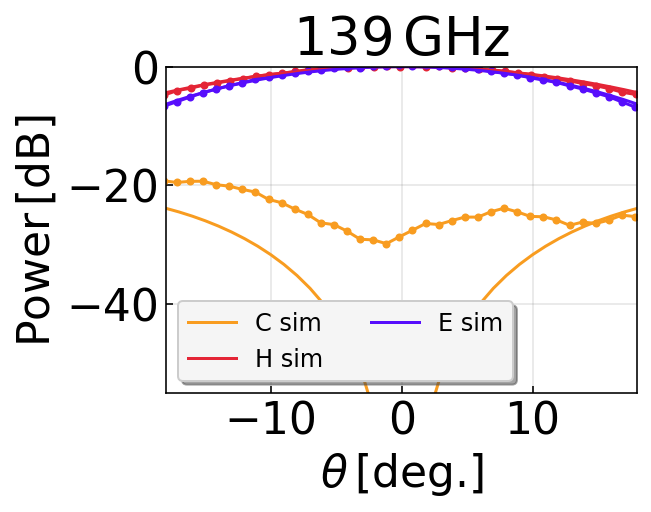

In [17]:
beam_mapper2(139,60, '21-1-2021',1,18)